In [10]:
import pandas as pd
data = pd.read_json("json_files/train.json")
data_cleaned = pd.read_json("json_files/train.json")
print(data.head())

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...


## 1. Data Understanding

### Total number of rows, cuisines, ingredients

In [14]:
# Convert the JSON data into a pandas DataFrame
df = pd.DataFrame(data)

# Calculate the metrics
total_rows = df.shape[0]  # Total number of rows
total_cuisines = df['cuisine'].nunique()  # Total number of unique cuisines
unique_ingredients = set(ingredient for ingredients_list in df['ingredients'] for ingredient in ingredients_list)
total_ingredients = len(unique_ingredients)  # Total number of unique ingredients

print(f"Total number of rows: {total_rows}")
print(f"Total number of cuisines: {total_cuisines}")
print(f"Total number of ingredients: {total_ingredients}")

Total number of rows: 39774
Total number of cuisines: 20
Total number of ingredients: 6714


### Cuisine Distribution

In [17]:
cuisine_counts = df['cuisine'].value_counts()
print(cuisine_counts)

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64


### Ingredient Counts

In [20]:
from collections import Counter

# Flatten the list of ingredients and count occurrences
all_ingredients = [ingredient for ingredients_list in df['ingredients'] for ingredient in ingredients_list]
ingredient_counts = Counter(all_ingredients)

# Most common 10 ingredients
most_common_10 = ingredient_counts.most_common(10)

# Least common 10 ingredients
least_common_10 = ingredient_counts.most_common()[:-11:-1]

print("Most Common 10 Ingredients:")
print(most_common_10)

print("\nLeast Common 10 Ingredients:")
print(least_common_10)

Most Common 10 Ingredients:
[('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7457), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4848), ('ground black pepper', 4785), ('all-purpose flour', 4632)]

Least Common 10 Ingredients:
[('crushed cheese crackers', 1), ('tomato garlic pasta sauce', 1), ('lop chong', 1), ('Hidden Valley® Greek Yogurt Original Ranch® Dip Mix', 1), ('Lipton® Iced Tea Brew Family Size Tea Bags', 1), ('ciabatta loaf', 1), ('cholesterol free egg substitute', 1), ('orange glaze', 1), ('Challenge Butter', 1), ('Oscar Mayer Cotto Salami', 1)]


## 2. Data PreProcessing

### Removing Descriptive Modifiers
The following factors have been taken in consider when merging ingredients
- Frequency of usage
- Meaning of modifier
    - Although "Old Bay Seasoning" was used in 98 recipes, out of 2212 total recipes which ends with the word "seasoning," it was merged because the modifier "Old Bay" refers to a brand
- Spacing issues
    - e.g. poppyseeds > poppy seeds

In [24]:
# Create a list of all unique ingredients across the dataset
unique_ingredients_list = set(ingredient.lower() for ingredients_list in df['ingredients'] for ingredient in ingredients_list)

# Convert the set to a sorted list for better readability
sorted_unique_ingredients = sorted(unique_ingredients_list)

# Extract the last word from each ingredient and count occurrences
last_word_counts = Counter(ingredient.split()[-1] for ingredient in sorted_unique_ingredients)

# Filter and print words used more than 15 times
frequent_last_words = {word: count for word, count in last_word_counts.items() if count > 15}

# Print the filtered dictionary
print("Words used more than 15 times:")
print(frequent_last_words)
print("count: ", len(frequent_last_words))

Words used more than 15 times:
{'sauce': 188, 'paste': 70, 'milk': 50, 'tomatoes': 51, 'beans': 80, 'cheese': 163, 'yogurt': 43, 'broth': 65, 'ham': 38, 'seasoning': 67, 'mix': 119, 'beef': 20, 'noodles': 45, 'juice': 71, 'powder': 83, 'squash': 17, 'flakes': 29, 'vinegar': 45, 'steaks': 29, 'water': 28, 'pepper': 50, 'flour': 70, 'butter': 38, 'extract': 30, 'liqueur': 30, 'oil': 70, 'syrup': 43, 'almonds': 16, 'pasta': 31, 'slices': 22, 'chile': 21, 'fillets': 55, 'sausage': 52, 'seeds': 37, 'apples': 18, 'bacon': 22, 'halves': 19, 'rice': 56, 'bread': 45, 'dressing': 44, 'leaves': 67, 'tortillas': 16, 'corn': 17, 'mushrooms': 32, 'potatoes': 24, 'salt': 41, 'chips': 29, 'crust': 20, 'chocolate': 18, 'spray': 16, 'sugar': 48, 'peppers': 21, 'mayonnaise': 17, 'soup': 45, 'roast': 32, 'steak': 36, 'meat': 34, 'stock': 44, 'onion': 18, 'cream': 56, 'dough': 21, 'salsa': 22, 'garlic': 17, 'chicken': 25, 'olives': 30, 'peas': 19, 'chops': 20, 'crumbs': 23, 'rolls': 33, 'buns': 19, 'mustar

#### Filter unique ingredients that end with "milk"

In [27]:
def cleaned_with_frequency(ingredients, data):
    # Extract the last word of the first ingredient (e.g., "squash" from "banana squash")
    last_word = ingredients[0].split()[-1].lower()
    # Count rows where the generalized last word is used
    rows_with_last_word = df[df['ingredients'].apply(
        lambda x: any(last_word in ingredient.lower() for ingredient in x)
    )]
    total_last_word_count = len(rows_with_last_word)
    # Count rows where each specific ingredient is used
    ingredient_frequencies = {}
    for ingredient in ingredients:
        rows_with_ingredient = df[df['ingredients'].apply(
            lambda x: any(ingredient.lower() in ingredient_in_row.lower() for ingredient_in_row in x)
        )]
        total_ingredient_count = len(rows_with_ingredient)
        
        # Calculate percentage frequency
        if total_last_word_count > 0:
            percentage_frequency = (total_ingredient_count / total_last_word_count) * 100
        else:
            percentage_frequency = 0
        
        # Add to the dictionary
        ingredient_frequencies[ingredient] = round(percentage_frequency, 2)
    
    return ingredient_frequencies

In [29]:
ingredients_with_ = [ingredient for ingredient in sorted_unique_ingredients if ingredient.endswith("mushrooms")]
print(ingredients_with_)

['baby portobello mushrooms', 'black mushrooms', 'black trumpet mushrooms', 'brown beech mushrooms', 'button mushrooms', 'chestnut mushrooms', 'chinese black mushrooms', 'cremini mushrooms', 'crimini mushrooms', 'diced mushrooms', 'dried black mushrooms', 'dried mushrooms', 'dried porcini mushrooms', 'dried shiitake mushrooms', 'dried wood ear mushrooms', 'fresh mushrooms', 'fresh shiitake mushrooms', 'green giant™ sliced mushrooms', 'maitake mushrooms', 'matsutake mushrooms', 'mixed mushrooms', 'mushrooms', 'oyster mushrooms', 'shimeji mushrooms', 'sliced mushrooms', 'straw mushrooms', 'tree ear mushrooms', 'white button mushrooms', 'white mushrooms', 'wild mushrooms', 'wood ear mushrooms', 'wood mushrooms']


### Function: Ingredient Cleaner

The clean_ingredients function processes a list of ingredient names by standardizing them using a predefined keyword_mapping dictionary. Each ingredient is normalized to lowercase to ensure case-insensitive matching and then checked for the presence of any keywords from the dictionary. If a keyword is found within an ingredient name, the function replaces the name with the corresponding value from the dictionary, appending it to a cleaned list. If no keywords match, the original ingredient name is preserved. This ensures that variations of ingredient names are grouped under a standardized name, reducing redundancy. The function returns the processed list of ingredients, where each name is either mapped to a generalized term or left unchanged if no match is found.

In [32]:
def clean_ingredients_with_mapping(ingredients, mapping):
    cleaned = []
    for ingredient in ingredients:
        # Normalize ingredient to lowercase for case-insensitive matching
        lower_ingredient = ingredient.lower()
        found = False
        # Check the mapping dictionary for matching keywords
        for generalized_name, keywords in mapping.items():
            # If any keyword matches, use the generalized name
            if any(keyword in lower_ingredient for keyword in keywords):
                cleaned.append(generalized_name)
                found = True
                break
        # If no mapping applies, keep the original ingredient
        if not found:
            cleaned.append(ingredient)
    # Return unique cleaned ingredients while preserving order
    return list(dict.fromkeys(cleaned))

#### Function: Merge or Leave Distinguisher
The function analyzes the usage of a specific ingredient in relation to a generalized ingredient within a recipe dataset to decide whether the specific ingredient should be merged with the generalized one or left as distinct. It calculates the total number of recipes that include the generalized ingredient and the specific ingredient, computes the percentage of recipes containing the specific ingredient relative to the generalized ingredient, and makes a decision based on a user-defined threshold. The function returns a dictionary with the total recipe counts for both ingredients, the computed percentage, and a decision ("merge" or "leave") depending on whether the specific ingredient’s percentage is below the threshold. This is particularly useful for cleaning and simplifying ingredient data while preserving significant variations in recipe datasets.

In [40]:
def analyze_ingredient_usage(data, specific_ingredient, generalized_ingredient, threshold=5):
    """
    Analyzes the usage of a specific ingredient compared to its generalized ingredient.
    """
    # Ensure 'ingredients' column is in list format
    data['ingredients'] = data['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
    # Filter recipes containing the generalized ingredient
    recipes_with_generalized = data[data['ingredients'].apply(
        lambda x: any(generalized_ingredient.lower() in ingredient.lower() for ingredient in x)
    )]
    total_with_generalized = len(recipes_with_generalized)
    
    # Filter recipes containing the specific ingredient
    recipes_with_specific = data[data['ingredients'].apply(
        lambda x: any(specific_ingredient.lower() in ingredient.lower() for ingredient in x)
    )]
    total_with_specific = len(recipes_with_specific)
    
    # Calculate the percentage of specific ingredient
    if total_with_generalized > 0:
        percentage = (total_with_specific / total_with_generalized) * 100
    else:
        percentage = 0

    # Decide whether to merge or leave
    decision = "merge" if percentage < threshold else "leave"
    
    return {
        "total_recipes_with_generalized": total_with_generalized,
        "total_recipes_with_specific": total_with_specific,
        "percentage": percentage,
        "decision": decision
    }

# Example usage
data = pd.read_json("json_files/train.json")  # Load the dataset


specific_ingredient = "cashew nuts"
generalized_ingredient = "water"
threshold = 5  # Percentage threshold

result = analyze_ingredient_usage(data, specific_ingredient, generalized_ingredient, threshold)

# Print results
print(f"Total recipes that use '{generalized_ingredient}': {result['total_recipes_with_generalized']}")
print(f"Total recipes that use '{specific_ingredient}': {result['total_recipes_with_specific']}")
print(f"Percentage of '{specific_ingredient}': {result['percentage']:.2f}%")
print(f"Decision: {result['decision']}")

Total recipes that use 'water': 9499
Total recipes that use 'cashew nuts': 218
Percentage of 'cashew nuts': 2.29%
Decision: merge


#### Mapping Applier Function

In [43]:
import pandas as pd
import json

def mapping_applier(data, mappings, output_json="train_cleaned.json", log_file="mapping_changes.txt"):
    """
    Applies ingredient mappings to clean the dataset and logs changes.

    Args:
        data (pd.DataFrame): The dataset containing an 'ingredients' column with lists of ingredients.
        mappings (dict): A dictionary mapping last words to standardized ingredients.
        output_json (str): Filename for the cleaned dataset.
        log_file (str): Filename for logging changes.

    Returns:
        None
    """
    changes = []  # List to store changes for logging

    def map_ingredient(ingredient):
        """Maps an individual ingredient based on the last-word mappings."""
        if not isinstance(ingredient, str):  # Ensure ingredient is a string
            return ingredient
#dried shiitake mushrooms > words = ["dried", "shiitake", "mushrooms"]
        words = ingredient.lower().split()  # Split ingredient into words
        last_word = words[-1] if words else ""  # Extract last word safely

        if last_word in mappings:  # Check if last word exists in mappings
            word_mapping = mappings[last_word]  # Get mapping dictionary
#"mushrooms" : ["diced mushrooms", "fresh mushrooms", "sliced mushrooms"],
#"shiitake mushrooms" : ["shiitake"]
            for key, value in word_mapping.items():
                for i in value:
                    if i in words:  # Ensure full word matches
                        if ingredient != key:  # Only log changes
                            changes.append(f'"{ingredient}" > "{key}"')
                        return key  # Apply mapping

        return ingredient  # Return unchanged if no mapping applies

    # Apply mapping correctly by iterating through ingredient lists
    data_cleaned["ingredients"] = data_cleaned["ingredients"].apply(
        lambda ingredient_list: [map_ingredient(ingredient) for ingredient in ingredient_list]
        if type(ingredient_list) == list else ingredient_list  # Ensure it's a list
    )

    # Save the cleaned dataset
    data.to_json(output_json, orient="records", indent=4)

    # Save mapping log
    if changes:  # Only write if there are changes
        with open(log_file, "w") as log:
            log.write("\n".join(changes))
        print(f"Mapping applied. Cleaned dataset saved to {output_json}. Changes logged in {log_file}.")
    else:
        print("No mappings applied. Check your mapping dictionary or input data.")



In [45]:
# Example mapping dictionary (only showing for 'salt', you should add all 76 mappings)
mappings = {
    "sauce": {
        "tomato sauce" : ["tomato", "pasta", "spaghetti", "ragu", "prego", "marinara", "italian"],
        "soy sauce" : ["soy", "tamari"],
        "barbeque sauce" : ["barbecue", "barbeque", "bbq"],
        "worcestershire sauce" : ["worcestershire"],
        "hot sauce" : ["pepper", "hot", "chili", "chill", "chile"],
        "enchilada sauce" : ["enchilada"],
        "bean sauce" : ["bean"],
        "teriyaki sauce" : ["teriyaki", "kung", "fish"],
        "fish sauce" : ["fish"],
        "oyster sauce" : ["oyster"],
        "picante sauce" : ["picante"],
        "tartar sauce" : ["tartar"],
        "cranberry sauce" : ["cranberry"],
        "alfredo sauce" : ["alfredo"],
        "sweet and sour sauce" : ["sour"],
        "apple sauce": ["apple"],
        "plum sauce" : ["plum"],
        "arrabbiata sauce" : ["arrabbiata"]
    },
    "paste": {
        "tomato paste": ["tomato"],
        "hot paste": ["hot"] ,
        "chili paste": ["chilli", "chile", "chili"] ,
        "curry paste": ["curry"],
        "hot paste": ["hot"] ,
        "soy bean paste": ["soy bean"] ,
        "red bean paste" : ["sweet bean paste", "sweet red bean paste", "bean paste", "fermented"],
        "sesame paste" : ["sesame"]
    },
    "milk": {
        "chocolate milk" : ["chocolate"],
        "coconut milk" : ["coconut"],
        "buttermilk" : ["buttermilk"],
        "almond milk" : ["almond"],
        "soy milk" : ["soy"],
        "evaporated milk" : ["evaporated", "condensed"],
        "cashew milk" : ["cashew"],
        "powdered milk" : ["powdered", "dry", "dried"],
        "sour milk" : ["sour"],
        "oat milk" : ["skim"],
        "evaporated milk" : ["evaporated", "carnation"]
        },
    "tomatoes": {
        "plum/cherry tomatoes": ["plum tomatoes", "italian plum tomatoes","cherry tomatoes"],
        "grape tomatoes": ["grape tomatoes"],
        "green tomatoes": ["green tomatoes"]
    },
    "beans": {
        "refried beans": [
        "refried beans", "fat-free refried beans", "reduced sodium refried beans",
        "vegetarian refried beans", "low-fat refried beans", "old el paso™ refried beans", "refried black beans"
        ],
        "black beans": [
        "black beans", "canned black beans", "dried black beans", "reduced sodium black beans",
        "seasoned black beans", "no-salt-added black beans", "progresso black beans", "kroger black beans",
        "low sodium black beans", "refried black beans"
        ],
        "kidney beans": [
        "kidney beans", "red kidney beans", "light kidney beans", "light red kidney beans",
        "dried kidney beans", "reduced sodium kidney beans", "white kidney beans"
        ],
        "lima beans": [
        "lima beans", "baby lima beans", "fresh lima beans", "frozen lima beans"
        ],
        "pinto beans": [
        "pinto beans", "dried pinto beans", "low sodium pinto beans"
        ],
        "red beans": [
        "red beans", "small red beans", "sweetened red beans"
        ],
        "white beans": [
        "white beans", "white cannellini beans", "giant white beans", "small white beans", "great northern beans", "cannellini beans"
        ],
        "green beans": [
        "green beans", "long green beans", "frozen green beans", "string beans", "wax beans"
        ],
        "edamame beans": [
        "green soybeans", "edamame beans", "frozen edamame beans"
        ],
        "coffee beans": [
        "chocolate covered coffee beans", "chocolatecovered espresso beans", "coffee beans", "espresso beans"
        ]
    },
    "cheese": {
        "cheddar cheese": ["cheddar"],
        "mozzarella cheese": ["mozzarella", "italian", "string"],
        "cream cheese": ["cream"],
        "cottage cheese" : ["cottage"],
        "jack cheese" : ["jack"],
        "goat cheese" : ["goat"],
        "swiss cheese" :["swiss", "jarlsberg"],
        "manchego cheese" : ["manchego"],
        "blue cheese" : ["blue", "stilton", "roquefort"],
        "parmesan cheese" : ["parmesan cheese", "parmigiano"],
        "gruyere cheese": ["gruyere", "grated gruyère"],
        "ricotta cheese" : ["ricotta cheese"],
        "romano cheese" : ["romano"],
        "mexican cheese" : ["mexican"],
        "american cheese" : ["american"],
        "cheese" : ["low-fat cheese", "shredded cheese", "reduced-fat cheese", "semi-soft cheese", "hard cheese", "herb cheesse", "processed cheese", "fresh cheese", "garlic herb spreadable cheese", "crumbled cheese", "vegan cheese"],
        "taco cheese" : ["taco"],
        "ricotta cheese" : ["ricotta"],
        "provolone cheese" : ["provolone"],
        "gouda cheese" : ["gouda"]
    },
    "yogurt" : {
        "greek yogurt": ["greek yogurt", "low-fat greek yogurt", "full-fat plain yogurt", "nonfat greek yogurt",
        "fat free greek yogurt", "whole milk greek yogurt", "yoplait® greek 100 blackberry pie yogurt",'greek style plain yogurt',
        "yoplait® greek 2% caramel yogurt", "plain low fat greek yogurt","low-fat greek yogurt","honey-flavored greek style yogurt",
        "lowfat plain greekstyle yogurt","strained yogurt"],
        "frozen yogurt": ['coffee low-fat frozen yogurt', 'nonfat frozen yogurt','vanilla low-fat frozen yogurt',
        'nonfat vanilla frozen yogurt', 'vanilla frozen yogurt'],
        "vanilla yogurt":['vanilla lowfat yogurt','nonfat vanilla yogurt','low-fat vanilla yogurt'],
        "yogurt":['plain low-fat yogurt','low-fat plain yogurt','homemade yogurt','cream yogurt',
        "fat free yogurt",'low-fat natural yogurt','low-fat yogurt','natural yogurt', 'non dairy yogurt','plain yogurt'
        ,'vegan yogurt','strawberry yogurt','nonfat yogurt','plain whole-milk yogurt'],
        "soy yogurt":['plain soy yogurt','soy yogurt']
    },
    "broth" : {
        "chicken broth" : ["chicken"],
        "beef broth" : ["beef", "bone broth"],
        "vegetable broth" : ["vegetable"],
        "broth" : ["gluten-free broth", "low sodium broth"]
    },
    "ham": {
        "smoked ham": ['smoked','black forest ham'],
        "cooked ham": ['cooked','baked','boiled ham'],
        "ham":['']
    },
    "seasoning": {
        "taco seasoning" : ["taco"],
        "creole seasoning" :["creole"],
        "steak seasoning" :["steak"],
        "jerk seasoning" : ["jerk"],
        "cajun seasoning" : ["cajun"],
        "adobo seasoning" : ["adobo"],
        "barbeque seasoning" :["bbq", "barbeque", "barbecue"],
        "blackening seasoning" : ["black"],
        "greek seasoning" :["greek"],
        "steak seasoning" : ["steak", "meat"],
        "seafood seasoning" : ["crab", "seafood"],
        "pepper seasoning" : ["lemon pepper", "garlic pepper"],
        "italian seasoning" : ["italian"],
        "jerk seasoning" : ["jerk"],
        "poultry seasoning" :["poultry"]
    },
    "mix": {
        "seasoning mix": ["seasoning","creole spice mix",'cajun spice mix','tandoori masala mix'],
        "cake mix":["cake"],
        "stuffing mix":["stuffing"],
        "baking mix":["baking","biscuit","cookie","brownie",'jiffy corn muffin mix','cornbread','pizza','pie','muffin'
        ,"bread","gravy mix",'cornmeal mix'],
        "drink mix":["hot chocolate mix", "hot cocoa mix", "margarita mix", "bacardi® mixers margarita mix",
        "pina colada mix", "sour mix", "lipton lemon iced tea mix",'chocolate milk mix','bloody mary mix'],
        "dessert mix":["instant pudding mix", "instant butterscotch pudding mix", "powdered vanilla pudding mix",
        "custard dessert mix", "icing mix",'chocolate ice cream mix'],
        "soup mix":["soup",'knorr'],
        "ranch/salad mix":["ranch","salad",'dip mix','cole slaw mix','dressing','coleslaw','slaw'],
        "gravy mix":["gravy"],
        "curry":['curry'],
        "jambalaya mix":['jambalaya'],
        "rice mix":['rice'],
        "alfredo sauce":["alfredo sauce mix"]
    },
    "beef": {
        "beef fillet" : ["fillet"]
    },
    "noodles": {
        'rice noodles':['rice','vermicelli'],
        'egg noodles':['egg'],
        'buckwheat noodles':['buckwheat','soba'],
        'ramen noodels':['ramen','chuka'],
        'spaghetti noodles':['spaghetti'],
        'chinese noodles':['chinese','mein','hong','shanghai'],
        'lasagna noodles':['lasagna']
    },
    "juice": {
        "orange juice" : ["orange"],
        "clam juice" : ["clam"],
        "lemon juice" : ["lemon"],
        "lime juice" : ["lime"],
        "pineapple juice" : ["pineapple"],
        "vegetable juice" : ["vegetable juice", "v8", "v 8"],
        "tomato juice" : ["tomato"],
        "pickle juice" : ["pickle"],
        "sugarcane juice" : ["cane"],
        "apple juice" : ["unsweetened apple juice"],
        "grapefruit juice" : ["grapefruit"],
        "calamansi juice" : ["kalamansi"]
    },
    "powder":{
        "cocoa powder":['cocoa','cacao','vanilla'],
        "chili powder": [
        "achiote powder", "ancho powder", "chipotle chile powder", "chili powder", "hot chili powder",
        "red chile powder", "red chili powder", "salt free chili powder", "guajillo chile powder",
        "new mexico red chile powder", "habanero powder",'chile'],
        'curry powder':['curry'],
        'baking powder':['baking','meringue'],
        'milk powder':['milk','cream'],
        'bouillon powder':['bouillon','chicken-flavored soup powder'],
        'tea powder':['tea','espresso'],
        'asafetida powder':['asafetida','asafoetida'],
        'rice powder':['rice'],
        'five-spice powder':['five-spice'],
        'mustard powder':['mustard'],
        'file powder':['file'],
        'coriander powder':['coriander','dhaniya'],
        'mushroom powder':['porcini','mushroom']
    },
    "squash":{
        "squash" : ["banana squash", "winter squash", "buttercup squash", "delicata squash", "heirloom squash", "hubbard squash", "opo squash", "pattypan squash", "summer squash", "yellow crookneck squash", "yellow squash", "yellow summer squash"]
    },
    "flakes":{
        'chili flakes':['chili','chile'],
        'red pepper flakes':['red pepper'],
        'bonito flakes':['bonito'],
        'parsley flakes':['parsley'],
        'coconut flakes':['coconut'],
        'potato flakes':['potato'],
        'corn flakes':['cornflakes','corn'],
        'fish flakes':['fish'],
        'mint flakes':['mint']
    },
    "vinegar":{
        "rice vinegar" : ["rice vinegar"],
        "cider vinegar" : ["apple cider vinegar"],
        "wine vinegar" : ["wine vinegar", "sherry", "champagne"],
        "black vinegar" : ["black", "chinkiang"],
        "white vinegar" : ["white"],
        "red vinegar" : ["chinese red"],
        "balsamic vinegar" : ["balsamic"],
        "malt vinegar" : ["malt"]
    },
    "steaks":{
        'rib eye steaks':['rib eye'],
        'tuna steaks':['tuna'],
        'lamb steaks':['lamb'],
        'rump steaks':['rump'],
        'tenderloin steaks':['tenderloin'],
        'fillet steaks':['fillet','filet'],
        'fish steaks':['salmon'],
        'top loin steaks':['strip']
    },
    "water":{
        "water" : ["boiling water", "cold water", "hot water", "ice water", "mineral water", "spring", "tap water", "warm water"],
        "tuna in water" : ["tuna"],
        "rose water" : ["rose"],
        "carbonated water" : ["carbonated water", "seltzer water", "soda water", "sparkling"]
    },
    "pepper":{
        "chilli pepper":["chil",'ground pepper'],
        "black pepper":['black'],
        "dr pepper":['diet dr. pepper', 'dr pepper', 'dr. pepper'],
        "pepper":['long green pepper', 'long pepper','fresno','sichuan','chinese','bird','chipotle','poblano','cherry','pasilla','habanero'],
        "green bell pepper":['green bell pepper', 'green bellpepper','yellow bell pepper'],
        "bell pepper":['chopped bell pepper','diced bell peppe','orange bell pepper'],
        "cayenne pepper":['cayenne'],
        "white pepper":['white'],
        'red pepper':['crushed red pepper','ground red pepper']
    },
    "flour":{
        "all purpose flour" : ["purpose"],
        "barley flour" : ["barley"],
        "bread flour" : ["bread"],
        "corn flour" : ["corn"],
        "almond flour" : ["almond"],
        "wheat flour" : ["wheat"],
        "cake flour" : ["cake"],
        "self-raising flour" : ["self"],
        "pastry flour" : ["pastry"],
        "semolina flour" : ["semolina"],
        "rye flour" : ["rye"]
    },
    "butter":{
        'peanut butter':['peanut'],
        'unsalted butter':['unsalted'],
        'butter' : ['']
    },
    "extract":{
        "vanilla extract" : ["vanilla"],
        "maple extract" : ["maple"]
    },
    "liqueur":{
        'cream liqueur':['cream'],
        'chocolate liqueur':['chocolate'],
        'liqueur':['kirschenliqueur'],
        'southern liqueur':['southern'],
        'raspberry liqueur':['framboise']
    },
    "oil": {
        "olive oil" : ["olive"],
        "truffle oil" : ["truffle"],
        "coconut oil" : ["coconut", "palm"],
        "canola oil" : ["canola"],
        "vegetable oil" : ["vegetable"],
        "corn oil" : ["corn"],
        "almond oil" : ["almond"],
        "sesame oil" : ["sesame"],
        "tuna in oil" : ["tuna"]
    },
    "syrup":{
        'caramel syrup':['caramel'],
        'dark corn syrup':['dark'],
        'corn syrup':['karo','corn'],
        'syrup':['flavored','simple','pancake','table'],
        'maple syrup':['maple'],
        'ginger syrup':['ginger'],
        'peaches syrup':['peaches'],
        'brown rice syrup':['rice'],
        'barley malt syrup':['malt']
    },
    "almonds":{
        "marcona almonds" : ["marcona"],
        "tamari almonds" : ["tamari"]
    },
    "pasta":{
        'bow tie pasta':['bow-tie pasta'],
        'penne pasta':['penne'],
        'pasta' : ['']
    },
    "slices":{
        "sausage" : ["sausage"],
        "jack cheese" : ["jack cheese"],
        "mozzarella cheese" : ["mozzarella"],
        "american cheese" : ["american cheese"],
        "bacon" : ["bacon"],
        "pepperoni" : ["pepperoni"]
    },
    "chile":{
        'green chile':['green'],
        'arbol chile':['arbol'],
        'chile':['dried']
    },
    "fillets":{
        "bass fillets" : ["bass"],
        "flounder fillets" : ["flounder"],
        "cod fillets" : ["cod"]
    },
    "sausages":{
        'andouille sausage':['andouille'],
        'smoked sausage':['smoked'],
        'italian sausage':['italian'],
        'pork sausage':['pork'],
        'sausage':['hillshire farms low fat sausage'],
        'hot sausage':['hot','spicy'],
        'turkey sausage':['turkey'],
        'chicken sausage':['chicken']
    },
    "seeds":{
        "pumpkin seeds" : ["pumpkin"],
        "sesame seeds" : ["sesame"],
        "sunflower seeds" : ["sunflower"],
        "poppy seeds" : ["poppy"],
        "mustard seeds" : ["yellow mustard"]
    },
    "apples":{
        "apples" : ["cooking apples", "diced apples", "red", "sliced apples", "delicious"]
    },
    "bacon":{
        "bacon" : ["center cut bacon", "chopped bacon", "cooked bacon", "crispy bacon", "diced bacon", "oscar mayer bacon", "thick-cut bacon"],
        "streaky bacon" : ["streaky"]
    },
    "halves":{
        'chicken breast halves':['chicken'],
        'duck breast halves':['duck'],
        'pecan halves':['pecan'],
        'turkey breast halves':['turkey']
    },
    "rice":{
        "brown rice" : ["brown rice"],
        "white rice" : ["white rice"],
        "mexican rice" : ["mexican rice"],
        "spanish rice" : ["spanish", "risotto", "paella"],
        "rice" : ["sushi", "uncle ben's converted brand rice"]
    },
    "bread":{
        'country bread':['country'],
        'corn bread':['corn'],
        'bread':['gluten-free bread'],
        'pumpernickel bread':['pumpernickel'],
        'flatbread':['flat'],
        'sourdough bread':['sourdough'],
        'wheat bread':['wheat'],
        'white bread':['white']
    },
    "dressing":{
        "italian dressing" : ["hidden valley® farmhouse originals italian with herbs dressing", "italian"],
        "ranch dressing" : ["ranch"],
        "sesame ginger dressing" : ["sesame"],
        "vinaigrette dressing" : ["vinaigrette"],
        "caesar salad dressing" : ["caesar"],
        "salad dressing" : ["low-fat salad dressing"]
    },
    "leaves":{
        'basil leaves':['basil'],
        'leaves':['chopped leaves'],
        'collard green leaves':['collard'],
        'grape leaves':['grape','vine leaves']
    },
    "tortillas":{
        "corn tortillas" : ["corn"],
        "flour tortillas" : ["flour"],
        "wheat tortillas" : ["wheat"]
    },
    "corn":{
        'baby corn':['baby'],
        'popcorn':['popcorn'],
        'sweet corn':['sweet'],
        'pepper':['crushed peppercorn','ground peppercorn','whole peppercorn'],
        'corn':['ear of corn','yellow','frozen','fresh','canned']
    },
    "mushrooms": {
        "mushrooms" : ["diced mushrooms", "fresh mushrooms", "sliced mushrooms"],
        "shiitake mushrooms" : ["shiitake"]
    },
    "potatoes":{
        'sweet potatoes':['sweet'],
        'potatoes' : ['']
    },
    "salt":{
        "kosher salt" : ["kosher"],
        "coarse salt" : ["coarse"],
        "salt" : ["fine", "low sodium"]
    },
    "chips":{
        'tortilla chips' :['tortilla'],
        'miniature chocolate chips' :['miniature'],
        'pita chips':['pita'],
        'semisweet chocolate chips':['semi sweet','semisweet'],
        'chocolate chips':['mini']
    },
    "crust":{
        "pie crust" : ["pie", "double crust"],
        "pizza crust" : ["pizza"]
    },
    "chocolate":{
        'dark chocolate':['plain'] 
    },
    "spray":{
        "vegetable oil spray" : ["vegetable"],
        "olive oil spray" : ["olive oil"],
        "butter cooking spray" : ["butter"],
        "cooking spray" : ["cooking spray", "stick spray"]
    },
    "sugar":{
        'powdered sugar':['domino confectioners sugar'],
        'light borwn sugar':['light brown sugar','golden brown sugar','light brown'],
        'sugar':['granulated sugar','superfine','cane','granulated','confectioners'],
        'brown sugar':['brown sugar'],
        'organic sugar':['organic']
    },
    "peppers":{
        "jalapeno peppers" : ["jalapeno"],
        "serrano peppers" : ["serrano"],
        "chili peppers" : ["chile", "chili"],
        "bell peppers" : ["bell"],
        "sichuan peppers" : ["sichuan"]
    },
    "mayonnaise":{
        'basil mayonnaise':['basil'],
        'garlic mayonnaise':['garlic'],
        'japanese mayonnaise':['japanese','kewpie'],
        'mayonnaise' : ['']
    },
    "soup":{
        "cheese soup" : ["cheese"],
        "cream of chicken soup" : ["cream of chicken"],
        "cream of mushroom soup" : ["cream of mushroom"],
        "cream of tomato soup" : ["cream of tomato"],
        "tomato soup" : ["tomato"],
        "cream of broccoli soup" : ["cream of broccoli"],
        "cream of celery soup" : ["cream of celery"],
        "cream of potato soup" : ["cream of potato"],
        "onion soup" : ["onion soup"]
    },
    "roast":{
        'chuck roast':['chuck'],
        'beef roast':['beef roast'],
        'pork shoulder roast':['pork shoulder roast'],
        'pork roast':['center cut pork roast']
    },
    "steak":{
        "sirloin steak" : ["sirloin"],
        "rib eye steak" : ["ribeye"],
        "round steak" : ["round"],
        "steak" : ["leftover steak", "cooked steak"],
        "flank steak" : ["flank"],
        "lean steak" : ["lean"]
    },
    "meat":{
        'meat':['cooked meat','cubed meat','dark meat','chop','sliced'],
        'crab meat':['crab'],
        'luncheon meat':['luncheon'],
        'ground meat':['ground'],
        'minced meat':['minced','mincemeat'],
        'turkey meat':['turkey breast deli meat'],
        'duck meat':['duck'],
        'coconut meat':['coconut meat'],
        'beef meat':['beef']
    },
    "stock":{
        "chicken stock" : ["chicken"],
        "vegetable stock" : ["vegetable"],
        "beef stock" : ["beef"],
        "stock" : ["low sodium stock", "homemade stock"],
        "turkey stock" : ["turkey"]
    },
    "onion":{
        'sweet onion':['maui','bermuda'],
        'yellow onion':['yellow onion'],
        'purple onion':['purple onion'],
        'onion' : ['']
    },
    "cream":{
        "vanilla ice cream" : ["vanilla ice cream", "vanilla bean ice cream", "vanilla low-fat ic cream"],
        "sour cream" : ["sour cream"],
        "whipping cream" : ["whip"],
        "coconut ice cream" : ["coconut ice cream"],
        "coffee ice cream" : ["coffee ice cream"],
        "cream" : ["low fat cream"],
        "ice cream" : ["fat free ice cream"]
    },
    "dough":{
        'bread dough':['bread'],
        'pizza dough':['pizza'],
        'croissant dough':['croissant','crescent'],
        'wheat dough':['wheat'],
        'cookie dough':['cookie']
    },
    "salsa":{
        "salsa" : ["bottled low sodium"],
        "chunky salsa" : ["chunky"],
        "salsa" : ["herdez salsa", "medium salsa", "tomato"]
    },
    "garlic":{
        'black garlic':['black garlic'],
        'garlic' : ['']
    },
    "chicken":{
        "chicken" : ["low sodium chicken", "minced chicken", "whole chicken", "cut up", "sliced chicken", "diced chicken"],
        "broiler chicken" : ["broiler"],
        "popcorn chicken" : ["popcorn"],
        "chicken stock" : ["stock"]
    },
    "olives":{
        'black olives':['black'],
        'kalamata olives':['kalamata','calamata'],
        'olives':['oil cured olives','brine-cured olives','pitted','sliced'],
        'pimento olives':['pimento'],
        'green olives':['green']
    },
    "peas":{
        "peas" : ["fresh peas", "garden peas", "green peas"]
    },
    "chops":{
        'loin pork chops':['loin pork chops','center cut pork loin chops','pork loin chops'],
        'pork chops':['pork chops'],
        'lamb shoulder chops':['lamb shoulder chops','shoulder lamb chops']
    },
    "crumbs":{
        "bread crumbs" : ["bread"],
        "cracker crumbs" : ["cracker"]
    },
    "rolls":{
        'french rolls':['french'],
        'italian rolls':['italian'],
        'crescent rolls':['crescent'],
        'dinner rools':['dinner'],
        'sandwich rolls':['sandwich']
    },
    "buns":{
        "burger buns" : ["burger"]
    },
    "mustard":{
        'dijon mustard':['dijon'],
        'chinese mustard':['chinese'],
        'coarse mustard':['coarse'],
        'ground mustard':['ground','dry'],
        'mustard':['prepared','yellow'],
        'spicy brown mustard':['brown']
    },
    "shrimp":{
        "dried shrimp" : ["dried shrimp"],
        "shrimp" : ["deveined", "shelled"]
    },
    "wine":{
        'rice wine':['rice'],
        'cooking wine':['cooking','flavored'],
        'wine':['table'],
        'kosher wine':['passover']
    },
    "shells":{
        "pasta shells" : ["pasta shells"],
        "tostada shells" : ["tostada"]
    },
    "spread":{
        'spread' :['country crock® spread'],
        'buttery spread':['buttery',"i can't believ it' not butter! made with olive oil spread",
        "i can't believe it's not butter!® spread"],
        'cheese spread':['process cheese spread','velveeta cheese spread'],
        'raspberry spread':['raspberry'],
        'honey spread':['honey']
    },
    "tofu":{
        "silken tofu" : ["silken tofu"],
        "firm tofu" : ["firm tofu"],
        "tofu" : ["regular tofu"]
    }
}    
    
    


# Apply the mapping
mapping_applier(data_cleaned, mappings)

Mapping applied. Cleaned dataset saved to train_cleaned.json. Changes logged in mapping_changes.txt.


### Plural To Singular Mapping

In [56]:
data_mapped = pd.read_json("train_cleaned.json")
data_singular_changed = pd.read_json("train_cleaned.json")

In [58]:
def plural_to_singular_mapper(data, output_json="train_spacing_cleaned.json", log_file="spacing_changes.txt"):
    changes = []
    def clean_singular(ingredient):
        if not isinstance(ingredient, str):  # Ensure input is a string
            return ingredient
        ingredient
        
        cleaned = " ".join(ingredient.split())  # Normalize spaces

        if ingredient != cleaned:  # ✅ Log only if a change occurs
            changes.append(f'"{ingredient}" > "{cleaned}"')

        return cleaned

    # Apply spacing cleanup
    data_spacing_changed["ingredients"] = data_singular_changed["ingredients"].apply(
        lambda ingredient_list: [clean_spacing(ingredient) for ingredient in ingredient_list]
        if isinstance(ingredient_list, list) else ingredient_list  # Ensure it's a list
    )

    # Save the cleaned dataset
    data.to_json(output_json, orient="records", indent=4)

    # Save the changes log
    if changes:
        with open(log_file, "w") as log:
            log.write("\n".join(changes))
        print(f"Spacing cleaned. Cleaned dataset saved to {output_json}. Changes logged in {log_file}.")
    else:
        print("No spacing changes applied.")

In [60]:
import nltk
from nltk.stem import PorterStemmer
from nltk import pos_tag

In [62]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('punkt')  # For word_tokenize
nltk.download('punkt_tab')  # For word_tokenize
nltk.download('averaged_perceptron_tagger')  # For pos_tag
nltk.download('wordnet')  # For WordNetLemmatizer


[nltk_data] Downloading package punkt to /Users/jung-
[nltk_data]     kwangmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jung-
[nltk_data]     kwangmin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jung-kwangmin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/jung-
[nltk_data]     kwangmin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [64]:
data_mapped = pd.read_json("train_cleaned.json")
data_singular_changed = pd.read_json("train_cleaned.json")

In [65]:
p_to_s_mapping_applier(data_mapped)

NameError: name 'p_to_s_mapping_applier' is not defined

In [ ]:
def p_to_s_mapping_applier(data, output_json="train_singular_cleaned.json", log_file="singular_changes.txt"):
    changes = []

    lemmatizer = nltk.WordNetLemmatizer()


    def convert_to_singular(ingredient):
        # Use pos_tag to get parts of speech
        tokens = nltk.word_tokenize(ingredient)

        # Use pos_tag to get parts of speech
        tagged_words = pos_tag(tokens)
    
        # Convert plural nouns (NNS) and proper nouns (NNPS) to singular using lemmatization
        singular_words = [
            lemmatizer.lemmatize(word, pos='n') if tag in ['NNS', 'NNPS'] else word
            for word, tag in tagged_words
        ]

        cleaned = ' '.join(singular_words)

        if ingredient != cleaned:
            changes.append(f'"{ingredient}" > "{cleaned}"')
        # Join the words back into a string
        return cleaned

    # Apply spacing cleanup
    data_singular_changed["ingredients"] = data_mapped["ingredients"].apply(
        lambda ingredient_list: [convert_to_singular(ingredient) for ingredient in ingredient_list]
        if isinstance(ingredient_list, list) else ingredient_list  # Ensure it's a list
    )

    # Save the cleaned dataset
    data.to_json(output_json, orient="records", indent=4)

    # Save the changes log
    if changes:
        with open(log_file, "w") as log:
            log.write("\n".join(changes))
        print(f"Spacing cleaned. Cleaned dataset saved to {output_json}. Changes logged in {log_file}.")
    else:
        print("No changes applied.")

### Spacing Cleaner

In [110]:
data_singular_changed = pd.read_json("json_files/train_singular_cleaned.json")
data_spacing_changed = pd.read_json("json_files/train_singular_cleaned.json")

In [112]:
def spacing_cleaner(data, output_json="train_spacing_cleaned.json", log_file="spacing_changes.txt"):
    changes = []
    def clean_spacing(ingredient):
        """Removes extra spaces while keeping words separated correctly."""
        if not isinstance(ingredient, str):  # Ensure input is a string
            return ingredient
        
        cleaned = " ".join(ingredient.split())  # Normalize spaces

        if ingredient != cleaned:  # ✅ Log only if a change occurs
            changes.append(f'"{ingredient}" > "{cleaned}"')

        return cleaned

    # Apply spacing cleanup
    data_spacing_changed["ingredients"] = data_singular_changed["ingredients"].apply(
        lambda ingredient_list: [clean_spacing(ingredient) for ingredient in ingredient_list]
        if isinstance(ingredient_list, list) else ingredient_list  # Ensure it's a list
    )

    # Save the cleaned dataset
    data.to_json(output_json, orient="records", indent=4)

    # Save the changes log
    if changes:
        with open(log_file, "w") as log:
            log.write("\n".join(changes))
        print(f"Spacing cleaned. Cleaned dataset saved to {output_json}. Changes logged in {log_file}.")
    else:
        print("No spacing changes applied.")

In [114]:
spacing_cleaner(data_singular_changed)

Spacing cleaned. Cleaned dataset saved to train_spacing_cleaned.json. Changes logged in spacing_changes.txt.


## 3. Vectorization

### TF-IDF

In [78]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert Json file to Python object
file_path = '/Users/jung-kwangmin/PROJECT/culinarypreproject/json_files/train_spacing_cleaned.json'
with open(file_path, 'r') as file:
    data_spacing_changed = json.load(file)

# Defaultdict to store ingredients by cuisine
cuisine_ingredients = defaultdict(list)

# Combine ingredients by cuisine
for recipe in data_spacing_changed:
    cuisine_ingredients[recipe["cuisine"]].extend(recipe["ingredients"])

# Convert ingredients into a srting seperated by |||
cuisine_ingredients_str = {
    cuisine: "|||".join(ingredients) for cuisine, ingredients in cuisine_ingredients.items()
}


In [80]:
# Save the result to file
with open('cuisine_ingredients.txt', 'w') as file:
    for cuisine, ingredients_str in cuisine_ingredients_str.items():
        file.write(f"{cuisine}:\n{ingredients_str}\n\n")
print("데이터가 'cuisine_ingredients.txt' 파일에 저장되었습니다.")

데이터가 'cuisine_ingredients.txt' 파일에 저장되었습니다.


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Customized tokenizer
def custom_tokenizer(text):
    return text.split("|||")

# Make corpus
corpus = [str(value) for value in cuisine_ingredients_str.values()]

# Create object "MTfidfVectorizer"
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)

# Calsulate TF-IDF
tfidf_result = tfidf.fit_transform(corpus)

In [84]:
# Print idf values
print('\nidf values:')
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
    print(ele1, ':', ele2)


idf values:
(10 oz.) frozen chopped spinach : 3.3513752571634776
(10 oz.) frozen chopped spinach, thawed and squeezed dry : 2.9459101490553135
(14 oz.) sweetened condensed milk : 2.9459101490553135
(14.5 oz.) diced tomatoes : 2.9459101490553135
(15 oz.) refried beans : 3.3513752571634776
1% low-fat buttermilk : 2.6582280766035327
1% low-fat milk : 1.4054651081081644
2 1/2 to 3 lb. chicken, cut into serving pieces : 3.3513752571634776
2% low fat cheddar chees : 3.3513752571634776
2% lowfat greek yogurt : 3.3513752571634776
2% reduced-fat milk : 1.4795730802618863
33% less sodium ham : 3.3513752571634776
7 up : 2.6582280766035327
8 ounc ziti pasta, cook and drain : 3.3513752571634776
95% lean ground beef : 3.3513752571634776
abalone : 3.3513752571634776
abbamele : 3.3513752571634776
absinthe : 3.3513752571634776
abura age : 3.3513752571634776
acai juice : 3.3513752571634776
accent : 2.9459101490553135
accent seasoning : 3.3513752571634776
accompaniment : 3.3513752571634776
achiote : 3.3

In [86]:
# Print iword indexes
print('\nWord indexes:', tfidf.vocabulary_)


Word indexes: {'romaine lettuce': 4390, 'black olives': 446, 'grape tomatoes': 2345, 'garlic': 2207, 'pepper': 3804, 'purple onion': 4133, 'seasoning': 4574, 'garbanzo beans': 2201, 'feta cheese crumbles': 1899, 'ground pork': 2472, 'finely chopped fresh parsley': 1925, 'onions': 3617, 'salt': 4476, 'vinegar': 5495, 'caul fat': 861, 'minced garlic': 3389, 'dried oregano': 1708, 'red wine vinegar': 4272, 'olive oil': 3601, 'boneless chop pork': 520, 'lemon juice': 3032, 'orange': 3619, 'anise': 115, 'cinnamon sticks': 1194, 'unflavored gelatin': 5360, 'zinfandel': 5749, 'orange blossom honey': 3623, 'sugar': 5002, 'lemon': 3026, 'calimyrna figs': 754, 'clove': 1221, 'honey': 2621, 'whipping cream': 5550, 'plain whole-milk yogurt': 3942, 'fresh dill': 2047, 'yoghurt': 5726, 'myzithra': 3497, 'large eggs': 2987, 'cheese': 923, 'feta cheese': 1898, 'phyllo': 3834, 'kefalotyri': 2850, 'black pepper': 448, 'hamburger buns': 2529, 'paprika': 3707, 'chopped fresh mint': 1140, 'ground cinnamon

In [88]:
# Get the list of cuisine names
cuisine_names = [cuisine for cuisine in cuisine_ingredients_str.keys()]

# Print the list of cuisines
print(cuisine_names)

['greek', 'southern_us', 'filipino', 'indian', 'jamaican', 'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai', 'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese', 'irish', 'korean', 'moroccan', 'russian']


In [90]:
# Print tf-idf values in matrix form
print('\ntf-idf values in matrix form:')
print(tfidf_result.toarray())


tf-idf values in matrix form:
[[0.         0.00195651 0.         ... 0.00586952 0.03121474 0.        ]
 [0.         0.         0.         ... 0.         0.00315293 0.        ]
 [0.         0.         0.         ... 0.         0.00631432 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.03656641 0.        ]
 [0.         0.         0.         ... 0.         0.03258645 0.        ]
 [0.         0.         0.         ... 0.         0.0017587  0.        ]]


### Reduce dimension to use PCA

In [93]:
from sklearn.decomposition import TruncatedSVD

# Reduce to second dimension
svd = TruncatedSVD(n_components=2) 
reduced_matrix = svd.fit_transform(tfidf_result)

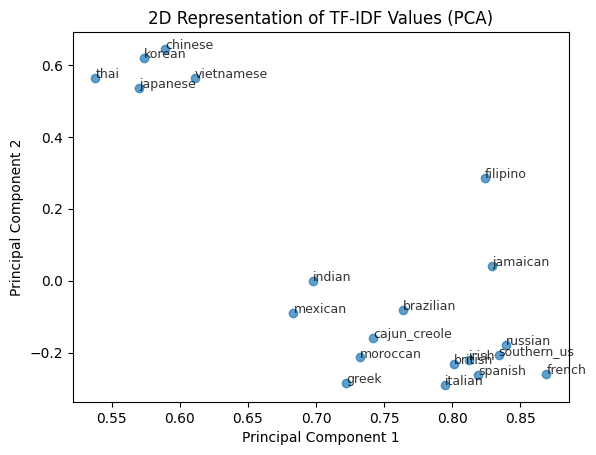

In [95]:
# Visualizing PCA results
import matplotlib.pyplot as plt

plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.7)

# Add cuisine names to each data point
for i, cuisine in enumerate(cuisine_names):  # cuisine_names is the list of cuisine names
    plt.text(reduced_matrix[i, 0], reduced_matrix[i, 1], cuisine, fontsize=9, alpha=0.8)

plt.title('2D Representation of TF-IDF Values (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### 4. Machine Learning

## K-means clustering

In [99]:
from sklearn.cluster import KMeans

# Create K-means clustering model
kmeans = KMeans(n_clusters=3, random_state=18)

# Train the model
kmeans.fit(reduced_matrix)

# Predict cluster labels
labels = kmeans.labels_

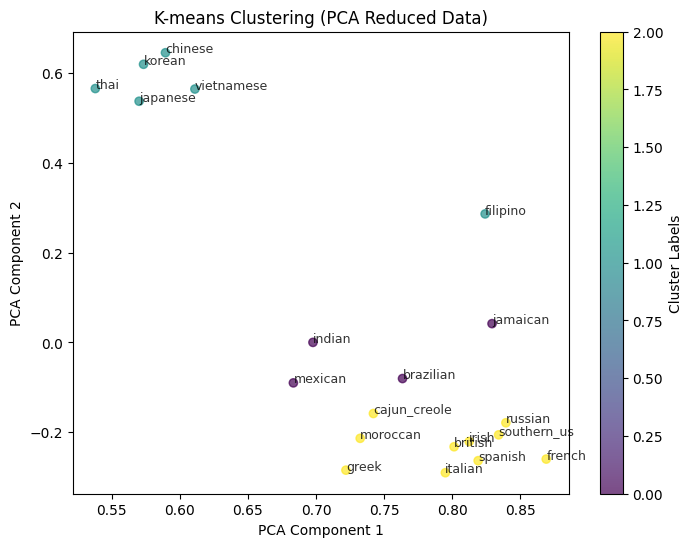

In [100]:
import matplotlib.pyplot as plt

# Visualizing clustering results
plt.figure(figsize=(8, 6))

# Visualizing each 100ster with a different color
scatter = plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels, cmap='viridis', alpha=0.7)

# Add cuisine names to each data point
for i, cuisine in enumerate(cuisine_names):  # cuisine_names is the list of cuisine names
    plt.text(reduced_matrix[i, 0], reduced_matrix[i, 1], cuisine, fontsize=9, alpha=0.8)

# Add a color bar for the clusters
plt.colorbar(scatter, label='Cluster Labels')  # Use color bar to display cluster labels

# Set labels and title
plt.title('K-means Clustering (PCA Reduced Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show;

In [102]:
from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
score = silhouette_score(reduced_matrix, labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.5685169074273827


In [106]:
# Maximum silhouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 값들을 저장할 리스트
sil_scores = []
n_clusters_range = range(2, 11)  # 군집 개수 범위 (2부터 10까지)

# random_state 범위 설정
random_states = range(10, 101)

# 최적의 n_clusters와 random_state를 찾기 위한 변수 초기화
best_score = -1
best_n_clusters = None
best_random_state = None

# n_clusters와 random_state 값을 변경하며 실험
for n_clusters in n_clusters_range:
    for state in random_states:
        kmeans = KMeans(n_clusters=n_clusters, random_state=state)
        kmeans.fit(reduced_matrix)  # reduced_matrix는 PCA로 차원 축소된 데이터
        
        # silhouette score 계산
        score = silhouette_score(reduced_matrix, kmeans.labels_)
        
        # 최적의 score를 갱신
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
            best_random_state = state

print(f"Best n_clusters: {best_n_clusters}")
print(f"Best random_state: {best_random_state}")
print(f"Best silhouette score: {best_score}")

Best n_clusters: 2
Best random_state: 10
Best silhouette score: 0.7672323571246908


In [107]:
# Maximum silhouette score when the number of clusters is fixed
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# 값들을 저장할 리스트
sil_scores = []
random_states = range(10, 101)  # random_state 값 범위 (예: 10에서 100까지)

# 반복하여 각 random_state에 대한 silhouette score 계산
for state in random_states:
    kmeans = KMeans(n_clusters=3, random_state=state)
    kmeans.fit(reduced_matrix)  # reduced_matrix는 PCA로 차원 축소된 데이터
    
    # silhouette score 계산
    score = silhouette_score(reduced_matrix, kmeans.labels_)
    sil_scores.append(score)

# 최적의 random_state 찾기
best_state = random_states[np.argmax(sil_scores)]
best_score = max(sil_scores)

print(f"Best random_state: {best_state}")
print(f"Best silhouette score: {best_score}")

Best random_state: 24
Best silhouette score: 0.6546309547732674
